<a href="https://colab.research.google.com/github/irenegauna/eur-usd-exchange-rate-predictor/blob/main/Predicci%C3%B3n_dolar_vs_euro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo de predicción con LSTM (Long Short-Term Memory)

####Adecuado para series temporales como los tipos de cambio

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.dates as mdates

In [16]:
#cargo los datos
data = pd.read_csv('/content/candles_iqoption_EURUSD_2020-11-4_2020-11-5.csv', index_col='Date', parse_dates=True)

#visualizo los datos
print(data.head())

                                  Date.1     Open    Close     High      Low  \
Date                                                                           
2020-11-04 18:18:00  2020-11-04 18:18:00  1.17132  1.17131  1.17137  1.17125   
2020-11-04 18:19:00  2020-11-04 18:19:00  1.17131  1.17145  1.17145  1.17127   
2020-11-04 18:20:00  2020-11-04 18:20:00  1.17146  1.17137  1.17146  1.17137   
2020-11-04 18:21:00  2020-11-04 18:21:00  1.17137  1.17132  1.17149  1.17132   
2020-11-04 18:22:00  2020-11-04 18:22:00  1.17133  1.17136  1.17138  1.17131   

                     Volume  
Date                         
2020-11-04 18:18:00      29  
2020-11-04 18:19:00      35  
2020-11-04 18:20:00      55  
2020-11-04 18:21:00      59  
2020-11-04 18:22:00      43  


In [17]:
#reviso si hay valores nulos
data.isna().sum()

,0
Date.1,0
Open,0
Close,0
High,0
Low,0
Volume,0


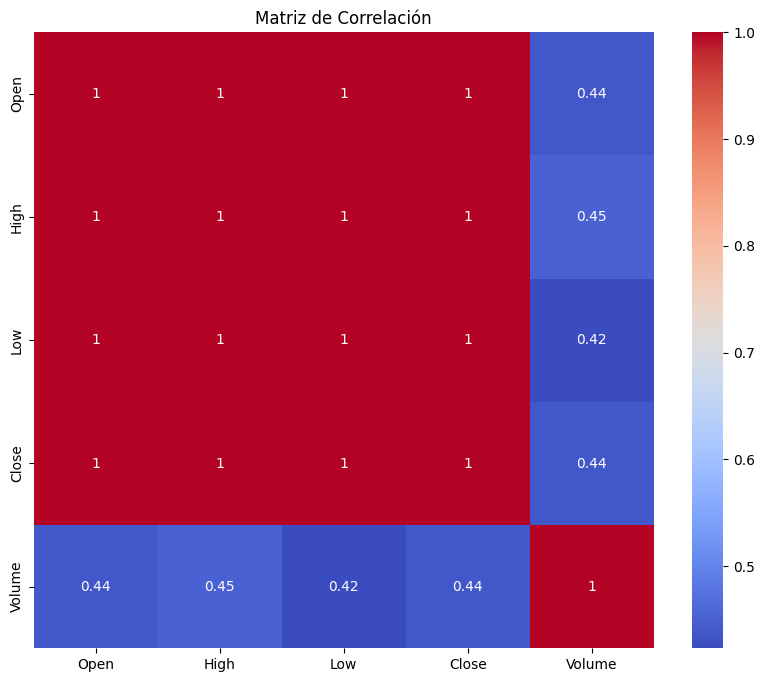

In [18]:
#reviso la correlación entre variables
plt.figure(figsize=(10,8))
sns.heatmap(data[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


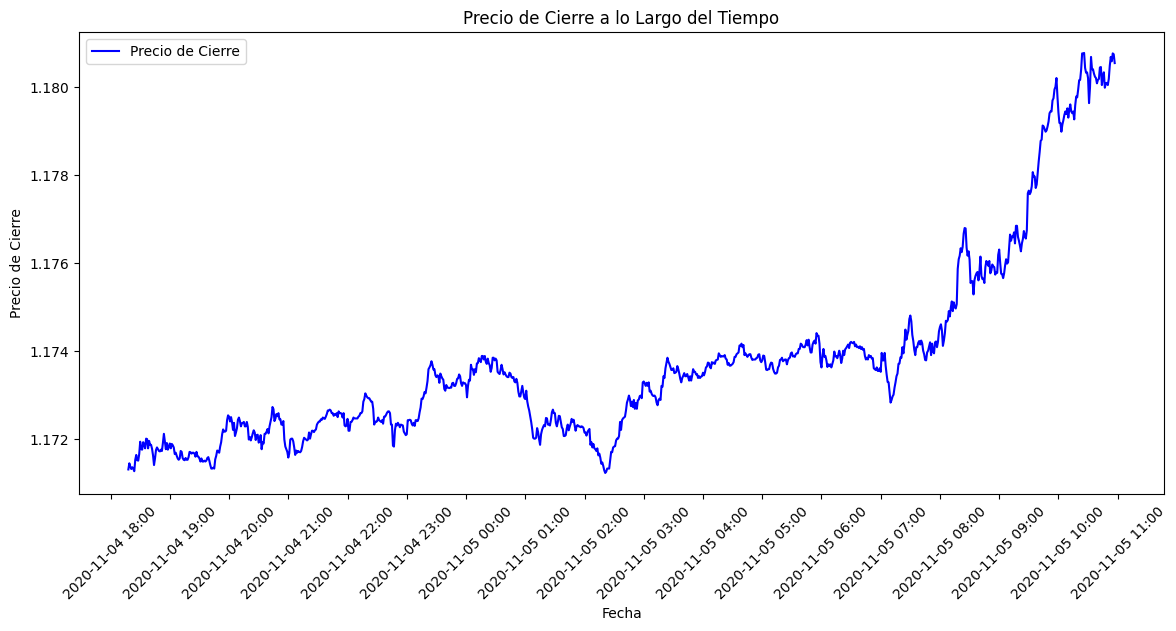

In [19]:
#visualización cómo los precios cambian a lo largo del tiempo
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Close'], label='Precio de Cierre', color='blue')

#mostrar el formato de fecha y hora bien en el eje y
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

plt.title('Precio de Cierre a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [20]:
#selecciono características y target
features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']

#normalizo los datos para mejorar rendimiento
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [21]:
#ahora tomo los valores entre el primer dato y el dato en la posición 59. Los almaceno en x. Y así sucesivamente.
#el cambio de divisa (dato en la posición 60) lo almaceno en y, que es valor que el modelo intentará predecir.
def crear_secuencias(data, rango):
    x, y = [], []
    for i in range(rango, len(data)):
        x.append(data[i-rango:i])
        y.append(data[i])
    return np.array(x), np.array(y)

rango= 60
x, y = crear_secuencias(scaled_features, rango)
y = scaled_target[rango:]
print(x[0:3])
print(y[0:3])


#divido los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

[[[0.00941423 0.00621118 0.01652893 0.05502846]
  [0.0083682  0.01449275 0.01859504 0.06641366]
  [0.02405858 0.01552795 0.02892562 0.10436433]
  [0.01464435 0.01863354 0.02376033 0.11195446]
  [0.01046025 0.00724638 0.02272727 0.08159393]
  [0.01359833 0.00828157 0.02479339 0.03036053]
  [0.0083682  0.00207039 0.01859504 0.04364326]
  [0.0041841  0.02484472 0.01859504 0.12713472]
  [0.03138075 0.04451346 0.04338843 0.17457306]
  [0.041841   0.03519669 0.04132231 0.09677419]
  [0.0292887  0.02898551 0.04132231 0.10436433]
  [0.0292887  0.03933747 0.04235537 0.12333966]
  [0.0460251  0.06521739 0.05991736 0.14231499]
  [0.07322176 0.07039337 0.06921488 0.18975332]
  [0.05648536 0.05383023 0.0661157  0.14611006]
  [0.05543933 0.06625259 0.06198347 0.12333966]
  [0.07322176 0.06625259 0.06714876 0.09867173]
  [0.06589958 0.0610766  0.07231405 0.08728653]
  [0.06066946 0.07246377 0.07231405 0.10056926]
  [0.08158996 0.07246377 0.09090909 0.07210626]
  [0.08054393 0.07142857 0.06921488 0.07

In [22]:
#utilizo un modelo LSTM sencillo
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2)) #ignoro aleatoriamente el 20% de las neuronas (para reducir overfitting)
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

#entreno el modelo
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0498 - val_loss: 0.0027
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Error cuadrático medio 0.0002428851571355316


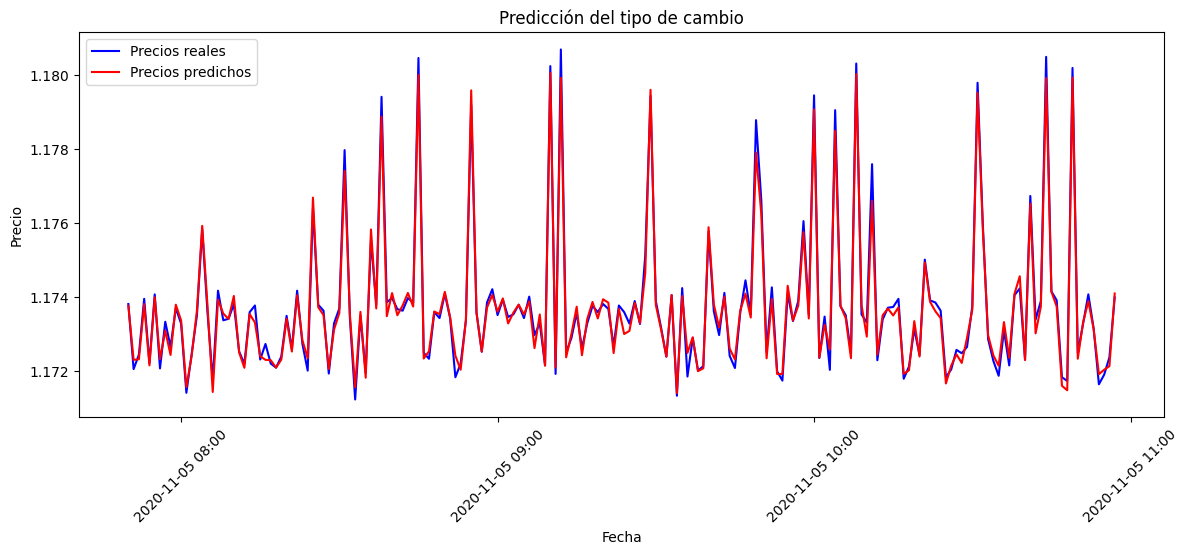

In [23]:
#realizo predicciones
predicted_prices = model.predict(x_test)
predicted_prices = scaler_target.inverse_transform(predicted_prices)

#evaluo el modelo
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_prices))
print(f'Error cuadrático medio {rmse}')

#visualizo los resultados
plt.figure(figsize=(14,5))
plt.plot(data.index[-len(y_test_actual):], y_test_actual, color='blue', label='Precios reales')
plt.plot(data.index[-len(predicted_prices):], predicted_prices, color='red', label='Precios predichos')

#vuelvo a mostrar bien hora y fecha en el eje y
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

plt.title('Predicción del tipo de cambio')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

#### Con este modelo, una empresa podría predecir los tipos de cambio futuros de EUR/USD y tomar decisiones sobre cuándo realizar conversiones de divisas o contratar seguros de cambio (hedging) basados en las predicciones

#### Un modelo así puede muy útil en la gestión del riesgo asociado a las fluctuaciones del tipo de cambio entre el euro y el dólar (modelo aplicable también a otras divisas)